# Spoken Language Understanding 

## Requirements

In [1]:
!pip3 install -q git+https://github.com/vasudevgupta7/gsoc-wav2vec2@main

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from pathlib import Path
from wav2vec2 import Wav2Vec2Config

config = Wav2Vec2Config()

print("TF version:", tf.__version__)

TF version: 2.9.2


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## DataSet

In [43]:
data_path = Path("../fluent_speech_commands_dataset")

In [44]:
train_data_path = data_path / "data/train_data.csv"

In [45]:
train_data_df = pd.read_csv(train_data_path)

In [46]:
train_data_df.head(5)

,Unnamed: 0,path,speakerId,transcription,action,object,location
0,0,wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-1...,2BqVo8kVB2Skwgyb,Change language,change language,none,none
1,1,wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-1...,2BqVo8kVB2Skwgyb,Resume,activate,music,none
2,2,wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-1...,2BqVo8kVB2Skwgyb,Turn the lights on,activate,lights,none
3,3,wavs/speakers/2BqVo8kVB2Skwgyb/1811b6e0-4474-1...,2BqVo8kVB2Skwgyb,Switch on the lights,activate,lights,none
4,4,wavs/speakers/2BqVo8kVB2Skwgyb/1d9f3920-4474-1...,2BqVo8kVB2Skwgyb,Switch off the lights,deactivate,lights,none


In [10]:
slots = ['action', 'object', 'location']
action_object_location = [train_data_df[slot].unique() for slot in slots]

In [11]:
action_object_location

[array(['change language', 'activate', 'deactivate', 'increase',
        'decrease', 'bring'], dtype=object),
 array(['none', 'music', 'lights', 'volume', 'heat', 'lamp', 'newspaper',
        'juice', 'socks', 'Chinese', 'Korean', 'English', 'German',
        'shoes'], dtype=object),
 array(['none', 'kitchen', 'bedroom', 'washroom'], dtype=object)]

In [12]:
from itertools import chain

targets = list(chain.from_iterable(action_object_location))
targets

['change language',
 'activate',
 'deactivate',
 'increase',
 'decrease',
 'bring',
 'none',
 'music',
 'lights',
 'volume',
 'heat',
 'lamp',
 'newspaper',
 'juice',
 'socks',
 'Chinese',
 'Korean',
 'English',
 'German',
 'shoes',
 'none',
 'kitchen',
 'bedroom',
 'washroom']

In [13]:
sos = 0
eos = 1
target_to_index = {target: i+2 for i, target in enumerate(targets)}
index_to_target = {index: target for target, index in target_to_index.items()}

In [14]:
action_object_location = list(zip(train_data_df['action'], train_data_df['object'], train_data_df['location']))
full_targets = np.asarray([[sos, target_to_index[action], target_to_index[obj], target_to_index[location], eos] for action, obj, location in action_object_location])

In [15]:
full_targets

array([[ 0,  2, 22, 22,  1],
       [ 0,  3,  9, 22,  1],
       [ 0,  3, 10, 22,  1],
       ...,
       [ 0,  2, 18, 22,  1],
       [ 0,  2, 19, 22,  1],
       [ 0,  4, 10, 25,  1]])

### Create DataSet

In [70]:
BATCH_SIZE = 4
TINY_SIZE = 128
AUDIO_MAXLEN = 246000

In [47]:
wav_files = train_data_df['path'][:TINY_SIZE+1].apply(lambda x: str(data_path / x))

In [65]:
wav, sample_rate = tf.audio.decode_wav(tf.io.read_file(wav_files[0]))
wav.shape, sample_rate

(TensorShape([29722, 1]), <tf.Tensor: shape=(), dtype=int32, numpy=16000>)

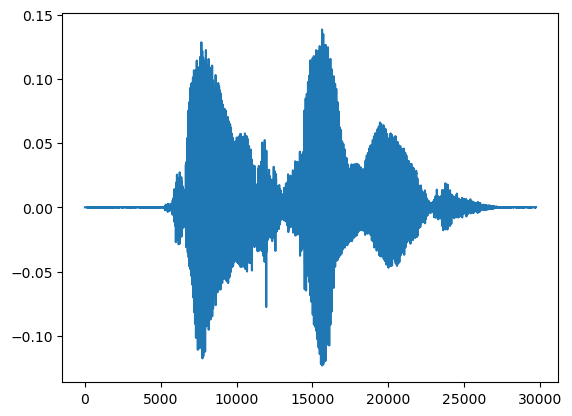

In [53]:
plt.plot(np.squeeze(wav.numpy()))
plt.show()

In [83]:
from wav2vec2 import Wav2Vec2Processor

processor = Wav2Vec2Processor(is_tokenizer=False)

def preprocess_speech(file_path):
    audio, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
    return processor(tf.transpose(audio))

In [88]:
audio = preprocess_speech(wav_files[2])

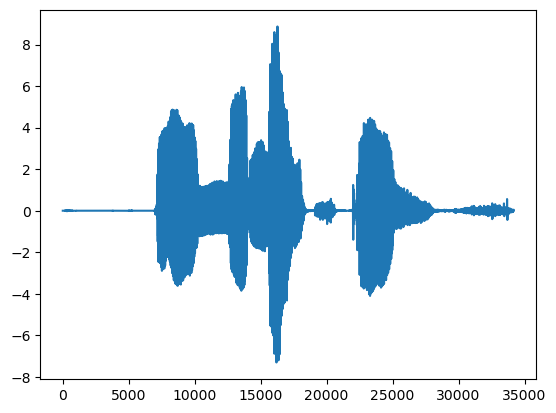

In [89]:
plt.plot(np.squeeze(audio.numpy()))
plt.show()

In [90]:
train_ds = tf.data.Dataset.from_tensor_slices(wav_files).map(preprocess_speech)
train_ds = train_ds.padded_batch(BATCH_SIZE, padded_shapes=AUDIO_MAXLEN, padding_values=0.0)

In [91]:
next(iter(train_ds))

<tf.Tensor: shape=(4, 246000), dtype=float32, numpy=
array([[-0.00016894, -0.00016894, -0.00016894, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00112627,  0.00112627,  0.00112627, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00031107,  0.00031107,  0.00031107, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00119347,  0.00119347,  0.00119347, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

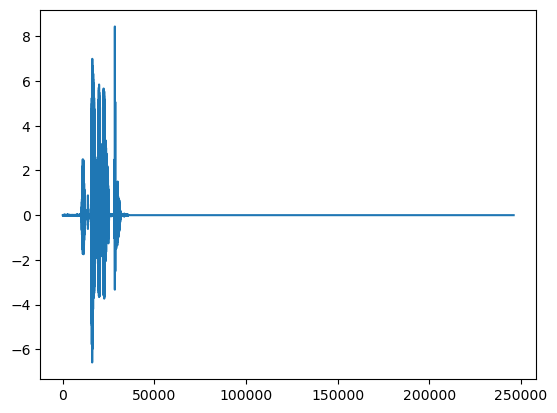

In [93]:
plt.plot(next(iter(train_ds))[3])
plt.show()

In [17]:
def split_targets(target):
    return target[:-1], target[1:]

def gerate_inputs_and_target(speech, target, next_target):
    return {"speech": speech, "target": target}, next_target

In [33]:
targets_next_targets = [split_targets(full_target) for full_target in full_targets[:TINY_SIZE]]
targets, next_targets = zip(*targets_next_targets)
targets = list(targets)
next_targets = list(next_targets)

In [34]:
next_targets

[array([ 2, 22, 22,  1]),
 array([ 3,  9, 22,  1]),
 array([ 3, 10, 22,  1]),
 array([ 3, 10, 22,  1]),
 array([ 4, 10, 22,  1]),
 array([ 5, 11, 22,  1]),
 array([ 5, 11, 22,  1]),
 array([ 6, 11, 22,  1]),
 array([ 5, 12, 22,  1]),
 array([ 5, 12, 22,  1]),
 array([ 6, 12, 22,  1]),
 array([ 6, 12, 22,  1]),
 array([ 6, 12, 22,  1]),
 array([ 6, 12, 22,  1]),
 array([ 4,  9, 22,  1]),
 array([ 4,  9, 22,  1]),
 array([ 3,  9, 22,  1]),
 array([ 3,  9, 22,  1]),
 array([ 3,  9, 22,  1]),
 array([ 3, 13, 22,  1]),
 array([ 3, 13, 22,  1]),
 array([ 3, 13, 22,  1]),
 array([ 4, 13, 22,  1]),
 array([ 4, 13, 22,  1]),
 array([ 4, 13, 22,  1]),
 array([ 3, 10, 23,  1]),
 array([ 3, 10, 23,  1]),
 array([ 3, 10, 23,  1]),
 array([ 3, 10, 23,  1]),
 array([ 3, 10, 23,  1]),
 array([ 3, 10, 23,  1]),
 array([ 3, 10, 23,  1]),
 array([ 3, 10, 23,  1]),
 array([ 3, 10, 24,  1]),
 array([ 3, 10, 24,  1]),
 array([ 3, 10, 25,  1]),
 array([ 3, 10, 25,  1]),
 array([ 3, 10, 25,  1]),
 array([ 3, 

## SLU Model

###  Wave2Vec Feature Extractor

In [6]:
AUDIO_MAXLEN = 246000
BATCH_SIZE = 2
wav2vec_layer = hub.KerasLayer("https://tfhub.dev/vasudevgupta7/wav2vec2/1", trainable=False)

Metal device set to: Apple M1


2022-09-10 00:20:15.766109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-10 00:20:15.766994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
inputs = tf.keras.Input(shape=(AUDIO_MAXLEN,))
hidden_states = wav2vec_layer(inputs)

feature_extractor = tf.keras.Model(inputs=inputs, outputs=hidden_states, name='feature_extractor')

y = feature_extractor(tf.random.uniform(shape=(BATCH_SIZE, AUDIO_MAXLEN)))

2022-09-10 00:37:54.724553: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-10 00:37:54.734275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [13]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 246000)]          0         
                                                                 
 keras_layer (KerasLayer)    (None, 768, 768)          94371712  
                                                                 
Total params: 94,371,712
Trainable params: 0
Non-trainable params: 94,371,712
_________________________________________________________________


In [12]:
y.shape

TensorShape([2, 768, 768])

### SLU Model with Decoder

In [7]:
vocab_size = len(index_to_target) + 2
embedding_dim = 32
latent_dim = 768
max_len = 4

In [14]:
inputs = tf.keras.Input(shape=(AUDIO_MAXLEN,))
speech_embeddings = wav2vec_layer(inputs)
hidden_state = tf.keras.layers.GlobalAveragePooling1D()(speech_embeddings)
# Decoder
dis_input = tf.keras.Input(shape=(max_len,), name='dis')
speech_embeddings = tf.keras.Input(shape=(latent_dim,), name='speech_embeddings')
x = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, input_length=max_input_len)(dis_input)
gru_decoder = tf.keras.layers.GRU(latent_dim, return_sequences=True)
x = gru_decoder(x, initial_state=speech_embeddings)
x = tf.keras.layers.Dropout(0.2)(x)
target_next_step = tf.keras.layers.Dense(vocab_size, activation='softmax')(x)
slu = tf.keras.Model(inputs=[inputs, dis_input], outputs=target_next_step, name='slu')

In [15]:
y = slu(tf.random.uniform(shape=(BATCH_SIZE, AUDIO_MAXLEN)))

In [16]:
y.shape

TensorShape([2, 768])